In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  

In [ ]:
filename = input("Enter filename in capital letters: ")

#### Data wrangling

In [3]:
df = pd.read_csv(f"./data_for_dashboard/{filename}.csv")
# df = df.set_index('datetime')
# df.index = pd.to_datetime(df.index)

In [4]:
df.head()

,datetime,open,high,low,close,volume,ml_target_combined,resistance,support,prev_close,...,stop_loss_price,target_price_short,stop_loss_price_short,exit_reason,per_bar_pnl,position,equity,bar_return,equity_peak,drawdown
0,2018-01-03 14:20:00+05:30,511.00,511.40,510.53,511.03,16671,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,100.0,0.0,100.0,0.0
1,2018-01-03 14:25:00+05:30,511.03,511.08,510.60,510.78,14803,0,NaN,NaN,511.03,...,NaN,NaN,NaN,NaN,0.0,0.0,100.0,0.0,100.0,0.0
2,2018-01-03 14:30:00+05:30,510.80,511.05,510.00,510.23,36254,0,NaN,NaN,510.78,...,NaN,NaN,NaN,NaN,0.0,0.0,100.0,0.0,100.0,0.0
3,2018-01-03 14:35:00+05:30,510.23,510.70,509.68,509.80,28281,0,NaN,NaN,510.23,...,NaN,NaN,NaN,NaN,0.0,0.0,100.0,0.0,100.0,0.0
4,2018-01-03 14:40:00+05:30,509.80,510.35,509.30,510.00,24471,0,NaN,NaN,509.80,...,NaN,NaN,NaN,NaN,0.0,0.0,100.0,0.0,100.0,0.0


In [5]:
# start_date = pd.Timestamp("2024-01-01", tz="Asia/Kolkata")
# end_date   = pd.Timestamp("2025-01-01", tz="Asia/Kolkata")

# df = df.loc[start_date:end_date]

In [6]:
df.head()

,datetime,open,high,low,close,volume,ml_target_combined,resistance,support,prev_close,...,stop_loss_price,target_price_short,stop_loss_price_short,exit_reason,per_bar_pnl,position,equity,bar_return,equity_peak,drawdown
0,2018-01-03 14:20:00+05:30,511.00,511.40,510.53,511.03,16671,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,100.0,0.0,100.0,0.0
1,2018-01-03 14:25:00+05:30,511.03,511.08,510.60,510.78,14803,0,NaN,NaN,511.03,...,NaN,NaN,NaN,NaN,0.0,0.0,100.0,0.0,100.0,0.0
2,2018-01-03 14:30:00+05:30,510.80,511.05,510.00,510.23,36254,0,NaN,NaN,510.78,...,NaN,NaN,NaN,NaN,0.0,0.0,100.0,0.0,100.0,0.0
3,2018-01-03 14:35:00+05:30,510.23,510.70,509.68,509.80,28281,0,NaN,NaN,510.23,...,NaN,NaN,NaN,NaN,0.0,0.0,100.0,0.0,100.0,0.0
4,2018-01-03 14:40:00+05:30,509.80,510.35,509.30,510.00,24471,0,NaN,NaN,509.80,...,NaN,NaN,NaN,NaN,0.0,0.0,100.0,0.0,100.0,0.0


In [7]:
columns = ["open", "high", "low", "close", "volume", "ml_target_combined"]
df =df[columns]

In [8]:

df.head()


,open,high,low,close,volume,ml_target_combined
0,511.00,511.40,510.53,511.03,16671,0
1,511.03,511.08,510.60,510.78,14803,0
2,510.80,511.05,510.00,510.23,36254,0
3,510.23,510.70,509.68,509.80,28281,0
4,509.80,510.35,509.30,510.00,24471,0


In [9]:
# fig, ax = plt.subplots(figsize=(10, 3))

# ax.plot(df["close"], label="Close")

# ax.set_xlabel("Bar Time")
# ax.set_ylabel("Closing Price")

# plt.legend()
# plt.tight_layout()
# plt.show()


In [10]:
df = df.copy()
df["resistance"] = df["close"].shift().rolling(10).max()
df["support"]    = df["close"].shift().rolling(10).min()

# df= df.dropna(how="any")


In [11]:
df[["close","support","resistance"]].head()

,close,support,resistance
0,511.03,NaN,NaN
1,510.78,NaN,NaN
2,510.23,NaN,NaN
3,509.80,NaN,NaN
4,510.00,NaN,NaN


In [12]:
# plot_ohlc_with_sr(df.tail(75))

    ATR implementation for stop loss

In [13]:
# Calculate True Range (Wilder's definition)
df['prev_close'] = df['close'].shift(1)
df['tr'] = df[['high', 'low', 'prev_close']].apply(
    lambda x: max(x['high'] - x['low'], 
                  abs(x['high'] - x['prev_close']), 
                  abs(x['low'] - x['prev_close'])), axis=1
)
df['atr'] = df['tr'].shift().rolling(14).mean()

#### Indicators as filter

In [14]:
# Calculate RSI (14-period standard)
def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Add RSI
df['rsi'] = calculate_rsi(df['close'], period=14).shift()  # shift to avoid lookahead


#### Creating Strategy

    Adding a trend filter.

In [15]:
# Add simple trend filter
df['sma_50'] = df['close'].shift().rolling(50).mean()
df['sma_200'] = df['close'].shift().rolling(200).mean()
df["sma_20"] = df["close"].shift().rolling(20).mean() 

# Uptrend: price > SMA50 > SMA200
df['uptrend'] = (
                 (df['sma_50'] > df['sma_200']) &
                 (df["close"]>df["sma_20"])
                 ).astype(int)

df["downtrend"] = ( 
                 (df['sma_50']< df['sma_200']) &
                 (df["close"]<df["sma_20"])
                 ).astype(int)


    Calculating Entry Signal 

In [16]:
df['entry_signal'] = (
    (df['low'] <= df['support']) &
    (df['rsi'] > 35) &
    (df['rsi'] < 55) &
    (df['uptrend'] == 1) 
    & (df['ml_target_combined']==1)
).astype(int)


    Calculating Entry Signal - Short 

In [17]:
df['entry_signal_short'] = (
    (df['high'] >= df['resistance']) &
    (df['rsi'] > 50) &  # Price showing strength/overbought
    (df['rsi'] < 70)   # But not extremely overbought
    & (df['downtrend'] == 1)
    & (df['ml_target_combined']==1)
).astype(int)

    Calculating Entry Price

In [18]:
df["entry_price"] = np.where(df["entry_signal"]==1, df["support"], np.nan)  #Long

In [19]:
# Entry at close when price touches resistance
df["entry_price_short"] = np.where(df["entry_signal_short"]==1, df["resistance"], np.nan) #Short

    Calculating Exit conditions

In [20]:
df["target_price"] = np.where(df["entry_signal"]==1, df["resistance"], np.nan ) #Long

df["stop_loss_price"] = np.where(df["entry_signal"]==1, df["entry_price"]-(1 * df["atr"]), np.nan) #Long

In [21]:

df["target_price_short"] = np.where(df["entry_signal_short"]==1, df["support"], np.nan) #Short

df["stop_loss_price_short"] = np.where(df["entry_signal_short"]==1, df["entry_price_short"] + (1 * df["atr"]), np.nan) #Short

#### Creating positions

    Initializing variables - Long

In [22]:
#Initializing trade pnl logic


df["exit_reason"] = ''
starting_capital = 100

entry_price = np.nan
stop_price = np.nan
target_price = np.nan

position = 0          # -1 short, 0 flat, +1 long
realized_pnl_cum = 0
prev_equity = starting_capital
shares = 1

TRANSACTION_COST = 0.0002



In [23]:
for i in range(len(df)):
    idx = df.index[i]
    current_bar_high = df.loc[idx, "high"]
    current_bar_low = df.loc[idx, "low"]
    
    # MTM
    if position != 0 and i > 0:
        prev_idx = df.index[i - 1]
        price_now = df.loc[idx, "close"]
        price_prev = df.loc[prev_idx, "close"]
        per_bar_pnl = position * shares * (price_now - price_prev)
    else:
        per_bar_pnl = 0.0
    df.loc[idx, "per_bar_pnl"] = per_bar_pnl

    
    # Exit logic
    exit_trade = False
    exit_price = None
    
    if position != 0:
        if position == 1:
            if current_bar_low <= stop_price:
                exit_trade = True
                exit_price = stop_price
                exit_reason = "STOP"
            elif current_bar_high >= target_price:
                exit_trade = True
                exit_price = target_price
                exit_reason = "TARGET"
        
        elif position == -1:
            if current_bar_high >= stop_price:
                exit_trade = True
                exit_price = stop_price
                exit_reason = "STOP"
            elif current_bar_low <= target_price:
                exit_trade = True
                exit_price = target_price
                exit_reason = "TARGET"
    
    # Exit execution
    if exit_trade:
        df.loc[idx, "per_bar_pnl"] = 0.0

        if i > 0:
            prev_idx = df.index[i - 1]
            price_prev = df.loc[prev_idx, "close"]
            exit_pnl = position * shares * (exit_price - price_prev)
        else:
            exit_pnl = 0.0
        
        exit_cost = exit_price * shares * TRANSACTION_COST
        exit_pnl -= exit_cost
        realized_pnl_cum += exit_pnl
        
        df.loc[idx, "exit_reason"] = exit_reason
        
        position = 0
        entry_price = np.nan
        stop_price = np.nan
        target_price = np.nan
    else:
        # Only add MTM if we didn't exit
        realized_pnl_cum += per_bar_pnl
    
    # Entry logic
    if position == 0:
        if df.loc[idx, "entry_signal"] == 1: # Entry logic long
            position = 1
            entry_price = df.loc[idx, "entry_price"]
            stop_price = df.loc[idx, "stop_loss_price"]
            target_price = df.loc[idx, "target_price"]
            shares = 1
            
            entry_cost = entry_price * shares * TRANSACTION_COST
            realized_pnl_cum -= entry_cost
        
        elif df.loc[idx, "entry_signal_short"] == 1:    #Entry logic short
            position = -1
            entry_price = df.loc[idx, "entry_price_short"]
            stop_price = df.loc[idx, "stop_loss_price_short"]
            target_price = df.loc[idx, "target_price_short"]
            shares = 1
            
            entry_cost = entry_price * shares * TRANSACTION_COST
            realized_pnl_cum -= entry_cost
    df.loc[idx, "position"] = position

    # Update equity
    equity = starting_capital + realized_pnl_cum
    bar_return = (equity - prev_equity) / prev_equity if prev_equity != 0 else 0.0
    prev_equity = equity
    
    df.loc[idx, "equity"] = equity
    df.loc[idx, "bar_return"] = bar_return

In [24]:
print(f"Final equity: {df['equity'].iloc[-1]}")
print(f"Total return: {(df['equity'].iloc[-1] / starting_capital - 1) * 100:.2f}%")

Final equity: 870.0174680000013
Total return: 770.02%


Final equity: 870.0174680000013
Total return: 770.02%

In [25]:
df["equity"]

0         100.000000
1         100.000000
2         100.000000
3         100.000000
4         100.000000
             ...    
148976    870.017468
148977    870.017468
148978    870.017468
148979    870.017468
148980    870.017468
Name: equity, Length: 148981, dtype: float64

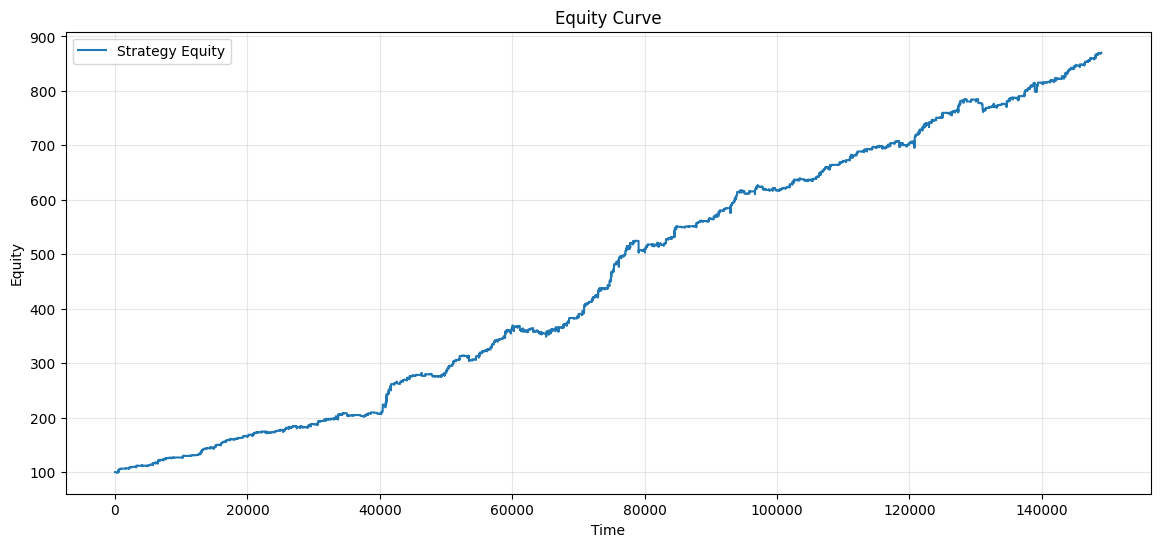

In [26]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["equity"], label="Strategy Equity")
plt.title("Equity Curve")
plt.xlabel("Time")
plt.ylabel("Equity")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [27]:
df["equity_peak"] = df["equity"].cummax()
df["drawdown"] = (df["equity"] - df["equity_peak"]) / df["equity_peak"]


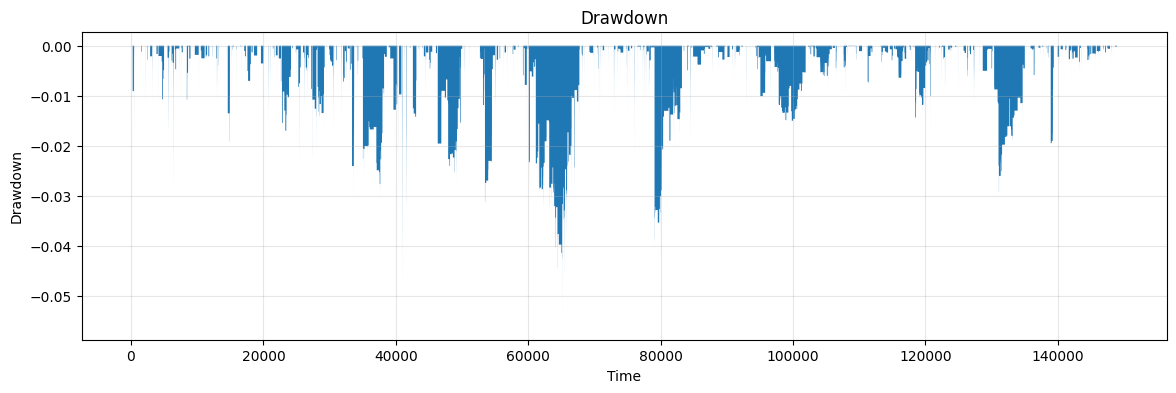

In [28]:
plt.figure(figsize=(14, 4))
plt.fill_between(df.index, df["drawdown"], 0)
plt.title("Drawdown")
plt.xlabel("Time")
plt.ylabel("Drawdown")
plt.grid(alpha=0.3)
plt.show()


In [29]:
import numpy as np

returns = df["bar_return"].dropna()

bars_per_year = 252 * 375   # India: ~375 minutes/day

sharpe = (
    returns.mean() / returns.std()
) * np.sqrt(bars_per_year)

print("Sharpe:", sharpe)


Sharpe: 6.5916039782371545


In [30]:
equity = df["equity"]

rolling_max = equity.cummax()
drawdown = (equity - rolling_max) / rolling_max

max_drawdown = drawdown.min()

print("Max Drawdown:", max_drawdown)


Max Drawdown: -0.0559423151952819


In [31]:
start_equity = equity.iloc[0]
end_equity = equity.iloc[-1]

total_minutes = len(equity)
minutes_per_year = 252 * 375

years = total_minutes / minutes_per_year

cagr = (end_equity / start_equity) ** (1 / years) - 1

print("CAGR:", cagr)


CAGR: 2.9441290570117795


In [32]:
calmar = cagr / abs(max_drawdown)

print("Calmar Ratio:", calmar)


Calmar Ratio: 52.62794445911819


In [33]:
# Trade count
num_trades = ((df["position"].shift(1) != 0) & (df["position"] == 0)).sum()
print("Trades:", num_trades)

# Time in market
print("Time in market:", (df["position"] != 0).mean())

# Sanity: equity monotonicity
print(df[["equity", "bar_return"]].head())
print(df[["equity", "bar_return"]].tail())


Trades: 1143
Time in market: 0.031030802585564603
   equity  bar_return
0   100.0         0.0
1   100.0         0.0
2   100.0         0.0
3   100.0         0.0
4   100.0         0.0
            equity  bar_return
148976  870.017468         0.0
148977  870.017468         0.0
148978  870.017468         0.0
148979  870.017468         0.0
148980  870.017468         0.0


#### For Dashboard

In [34]:
df["position_ml"] = df['position']
df['entry_signal_ml'] = df['entry_signal']
df['entry_signal_short_ml'] = df['entry_signal_short']
df['entry_price_ml'] = df['entry_price']
df['entry_price_short_ml'] = df['entry_price_short']
# df['entry_bar_ml'] = df['entry_bar']
df['exit_reason_ml'] = df['exit_reason']
# df['exit_bar_ml'] = df['exit_bar']
df['stop_loss_price_ml'] = df['stop_loss_price']
df['stop_loss_price_short_ml'] = df['stop_loss_price_short']
df['per_bar_pnl_ml'] = df['per_bar_pnl']
df['bar_return_ml'] = df['bar_return']

In [35]:
columns_to_be_appended = [
    'position',
    'entry_signal',
    'entry_signal_short',
    'entry_price',
    'entry_price_short',
    # 'entry_bar',
    'exit_reason',
    # 'exit_bar',
    'stop_loss_price',
    'stop_loss_price_short',
    'per_bar_pnl',
    'bar_return'
]

In [36]:
df_previous_data = pd.read_csv(f"./data_for_dashboard/{filename}.csv")

In [37]:
for columns in columns_to_be_appended:
    df[columns] = df_previous_data[columns]

In [ ]:
# df.to_parquet(
#     f"./data_for_dashboard_final/{filename}.parquet",
#     engine="pyarrow",
#     compression="snappy"
# )
